# Synthetic Discussions analysis

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import re
import shutil

import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy
import scikit_posthocs as sp

import tasks.stats
import tasks.postprocessing
import tasks.graphs

In [2]:
GRAPH_OUTPUT_DIR = Path("../graphs")
TOXICITY_TICKS = np.arange(1, 6, 1)
YTICKS_LIST = [TOXICITY_TICKS, TOXICITY_TICKS]
VMIN_TOXICITY = -1
VMAX_TOXICITY = 1

MODERATION_STRATEGY_MAP = {
    "vanilla": "No Instructions",
    "moderation_game": "Moderation Game",
    "no_moderator": "No Moderator",
    "erulemaking": "Human Mod. Guidelines",
    "constructive_communications": "Human Fac. Guidelines",
    "collective_constitution": "Rules Only",
}

MODEL_MAP = {
    "hardcoded": "hardcoded",
    "mistral-nemo-abliterated": "Mistral Nemo (abl.)",
    "qwen2.5-32b-4bit": "Qwen 2.5",
    "llama-3.1-70b-4bit": "LLaMa 3.1",
}

METRIC_MAP = {
    "toxicity": "Toxicity",
    "argumentquality": "Argument Quality"
}
METRICS = METRIC_MAP.values()

In [3]:
tqdm.tqdm.pandas()
sns.set(style="whitegrid")

## Preprocessing

In [4]:
shutil.unpack_archive("../data/dataset.zip", "../data")
full_df = pd.read_csv("../data/dataset.csv", encoding="utf8")

full_df.conv_variant = full_df.conv_variant.map(MODERATION_STRATEGY_MAP)
full_df.model = full_df.model.map(MODEL_MAP)
full_df = tasks.postprocessing.format_dataset(full_df, min_message_len=3)
full_df = full_df.rename(METRIC_MAP, axis=1)
full_df

,conv_id,message_id,message_order,conv_variant,model,user,user_prompt,is_moderator,intent,message,Toxicity,Argument Quality,not_intervened
0,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,1,Human Mod. Guidelines,hardcoded,SkepticalInvestor77,You are a human participating in an online cha...,False,Troll,How do you know he is not proud of his cakes? ...,4,3,False
1,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,1,Human Mod. Guidelines,hardcoded,SkepticalInvestor77,You are a human participating in an online cha...,False,Troll,How do you know he is not proud of his cakes? ...,3,2,False
2,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,1,Human Mod. Guidelines,hardcoded,SkepticalInvestor77,You are a human participating in an online cha...,False,Troll,How do you know he is not proud of his cakes? ...,3,2,False
3,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,1,Human Mod. Guidelines,hardcoded,SkepticalInvestor77,You are a human participating in an online cha...,False,Troll,How do you know he is not proud of his cakes? ...,3,2,False
4,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,1,Human Mod. Guidelines,hardcoded,SkepticalInvestor77,You are a human participating in an online cha...,False,Troll,How do you know he is not proud of his cakes? ...,4,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57316,8fd69250-71ad-4b24-9dca-0658d6eb95fc,-2304848861889816101,29,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"@WanderlustNomad22, thanks for sharing your in...",1,1,False
57317,8fd69250-71ad-4b24-9dca-0658d6eb95fc,-2304848861889816101,29,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"@WanderlustNomad22, thanks for sharing your in...",1,1,False
57318,8fd69250-71ad-4b24-9dca-0658d6eb95fc,-2304848861889816101,29,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"@WanderlustNomad22, thanks for sharing your in...",1,1,False
57319,8fd69250-71ad-4b24-9dca-0658d6eb95fc,-2304848861889816101,29,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"@WanderlustNomad22, thanks for sharing your in...",1,1,False


In [5]:
df = full_df[~full_df.not_intervened]
df.shape

(56375, 13)

## Analysis

### User intent impact on toxicity

In [6]:
no_hardocoded_df = full_df[full_df.model != "hardcoded"]

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/intent_barplot.png


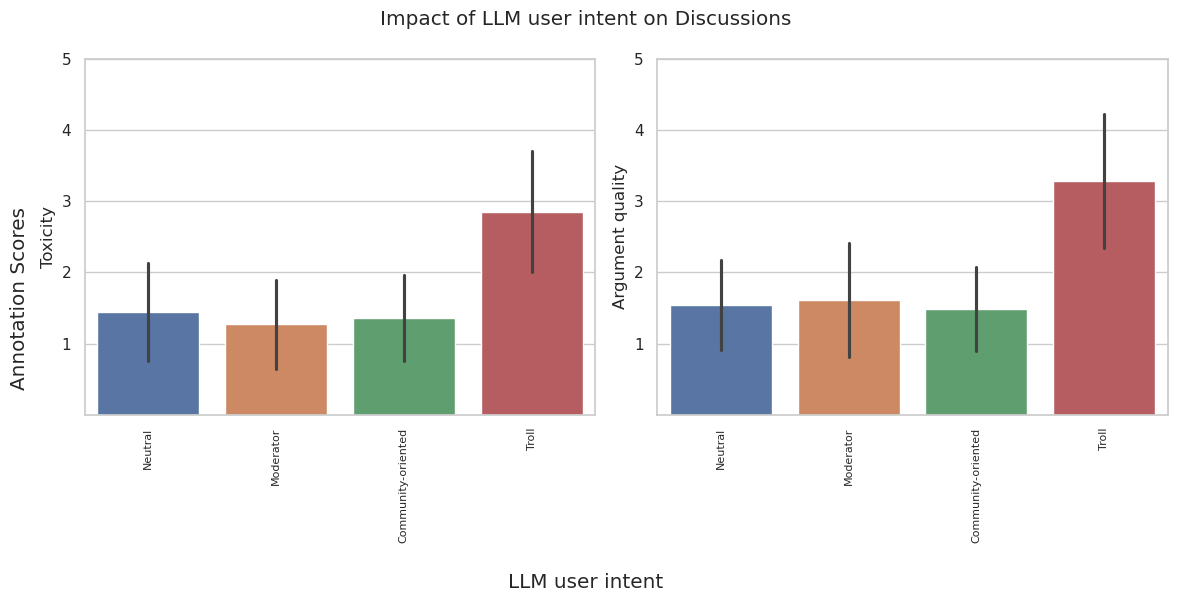

In [7]:
tasks.graphs.plot_metrics_barplots(
    df=no_hardocoded_df,
    group_by_col="intent",
    group_by_col_label="LLM user intent",
    metrics=METRICS,
    yticks_list=YTICKS_LIST,
)
tasks.graphs.save_plot(path=GRAPH_OUTPUT_DIR / "intent_barplot.png")
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/strategy_barplot.png


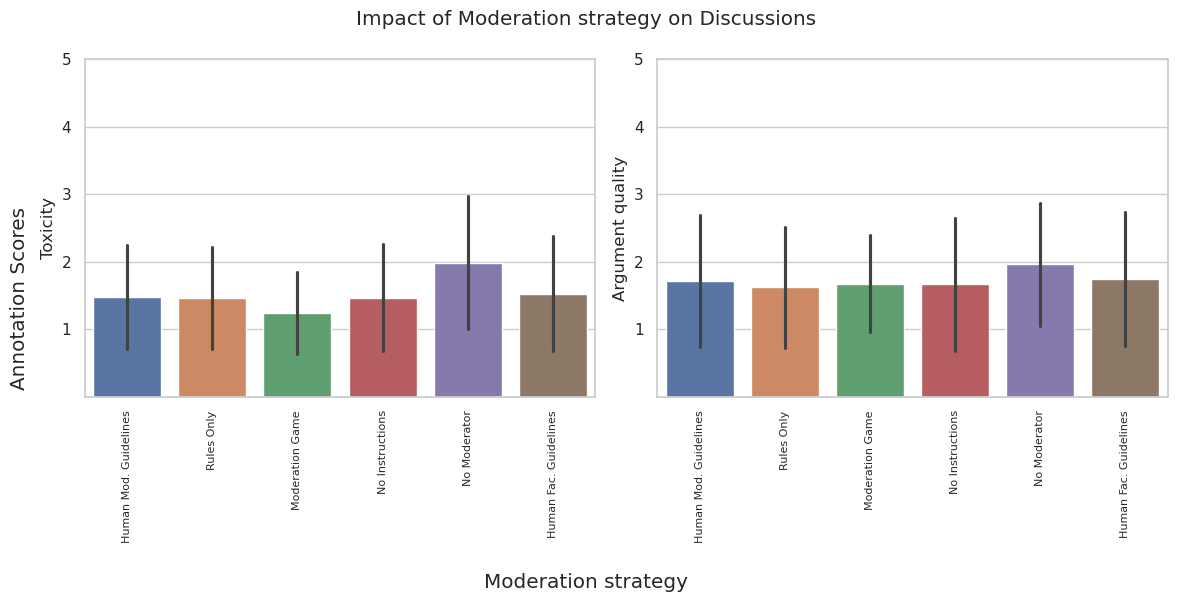

In [8]:
tasks.graphs.plot_metrics_barplots(
    df=no_hardocoded_df,
    group_by_col="conv_variant",
    group_by_col_label="Moderation strategy",
    metrics=METRICS,
    yticks_list=YTICKS_LIST,
)
tasks.graphs.save_plot(path=GRAPH_OUTPUT_DIR / "strategy_barplot.png")
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/model_barplot.png


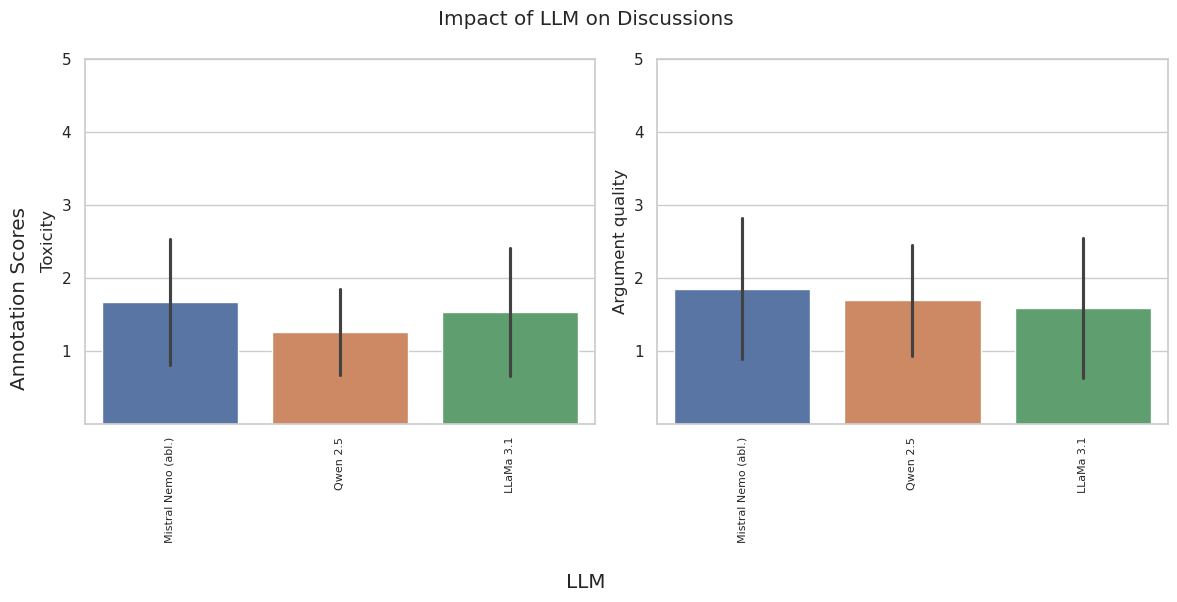

In [9]:
tasks.graphs.plot_metrics_barplots(
    df=no_hardocoded_df,
    group_by_col="model",
    group_by_col_label="LLM",
    metrics=METRICS,
    yticks_list=YTICKS_LIST,
)
tasks.graphs.save_plot(path=GRAPH_OUTPUT_DIR / "model_barplot.png")
plt.show()

### Moderator impact

In [10]:
no_mod_df = df.copy()
no_mod_df = no_mod_df[~no_mod_df.is_moderator]
contains_mod = no_mod_df.conv_variant != "No Moderator"
no_mod_df.loc[contains_mod, "message_order"] = (
    no_mod_df[contains_mod].message_order // 2 + 1
)

### Intent Impact

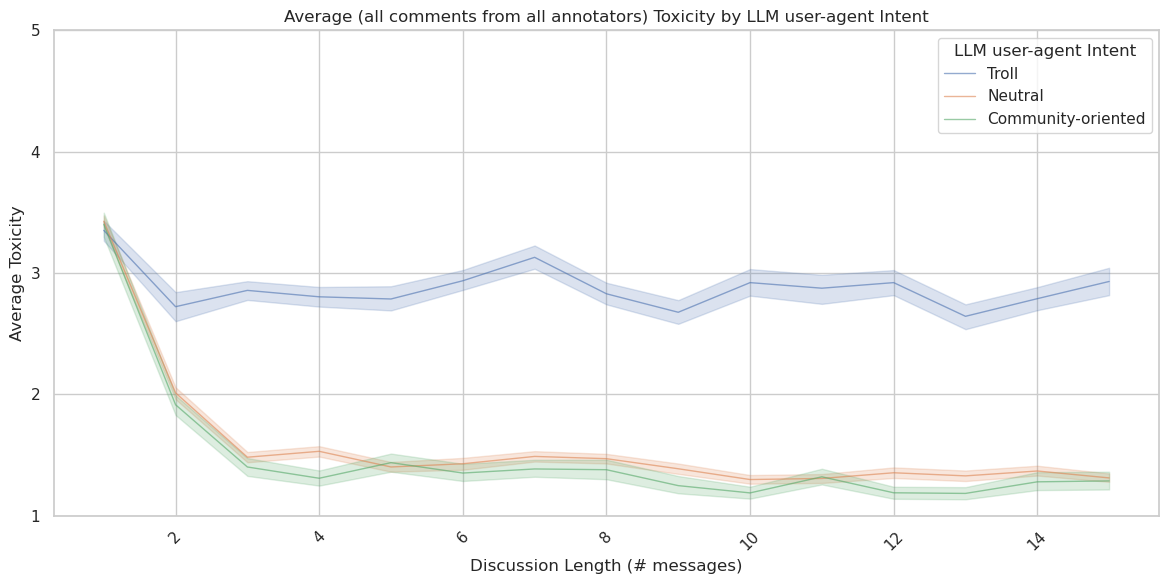

In [11]:
tasks.graphs.plot_timeseries(
    no_mod_df, y_col="Toxicity", hue_col="intent", hue_col_label="LLM user-agent Intent"
)
plt.yticks(TOXICITY_TICKS)
plt.show()

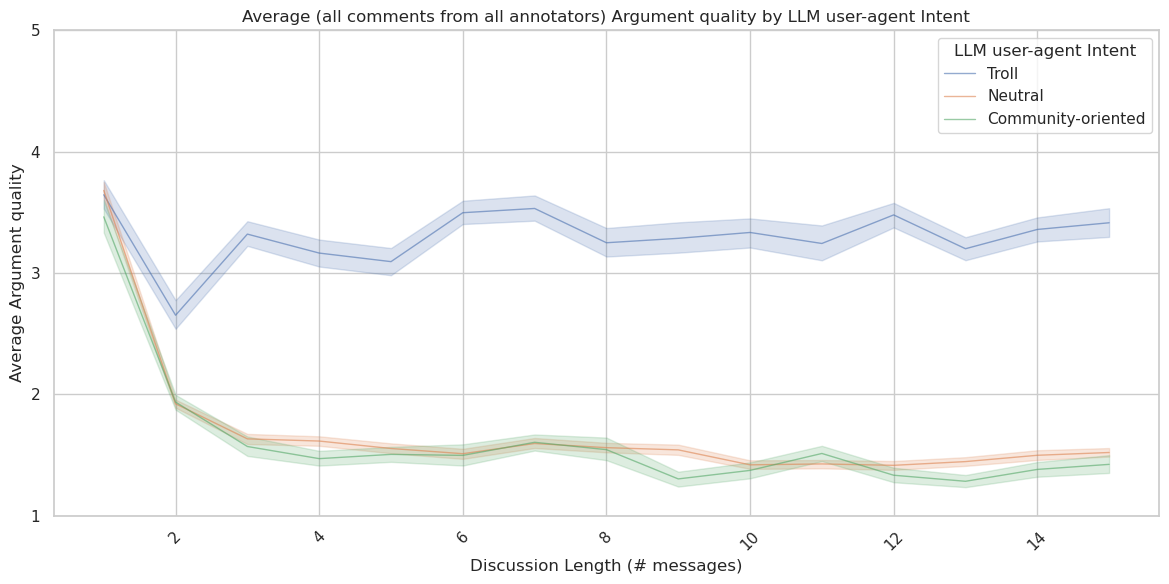

In [12]:
tasks.graphs.plot_timeseries(
    no_mod_df,
    y_col="Argument Quality",
    hue_col="intent",
    hue_col_label="LLM user-agent Intent",
)
plt.yticks(TOXICITY_TICKS)
plt.show()

### Moderation Strategy Impact

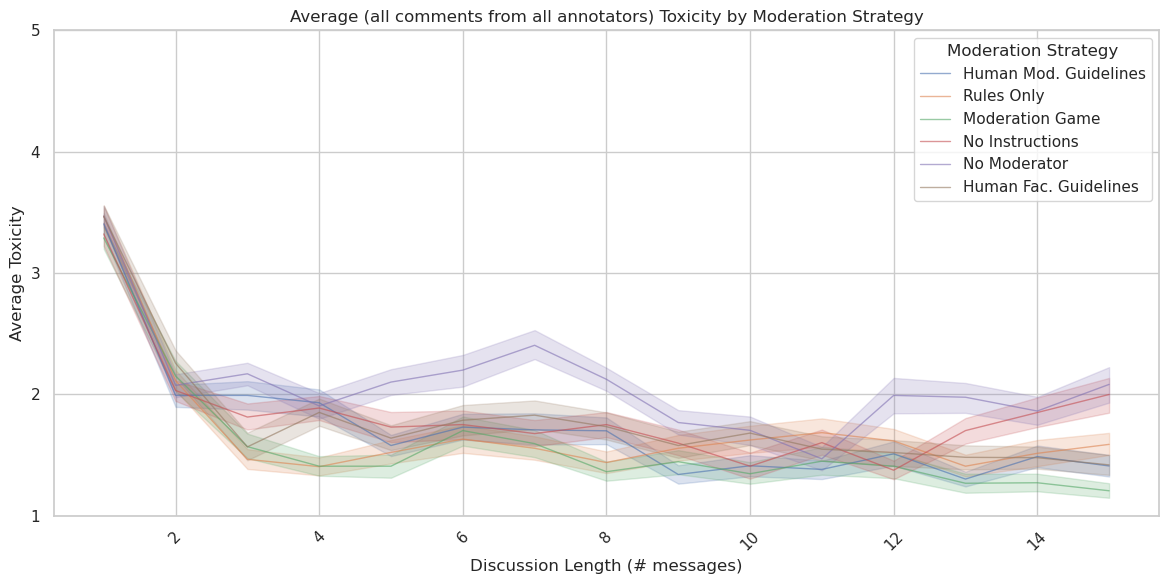

In [13]:
tasks.graphs.plot_timeseries(
    no_mod_df,
    y_col="Toxicity",
    hue_col="conv_variant",
    hue_col_label="Moderation Strategy",
)
plt.yticks(TOXICITY_TICKS)
plt.show()

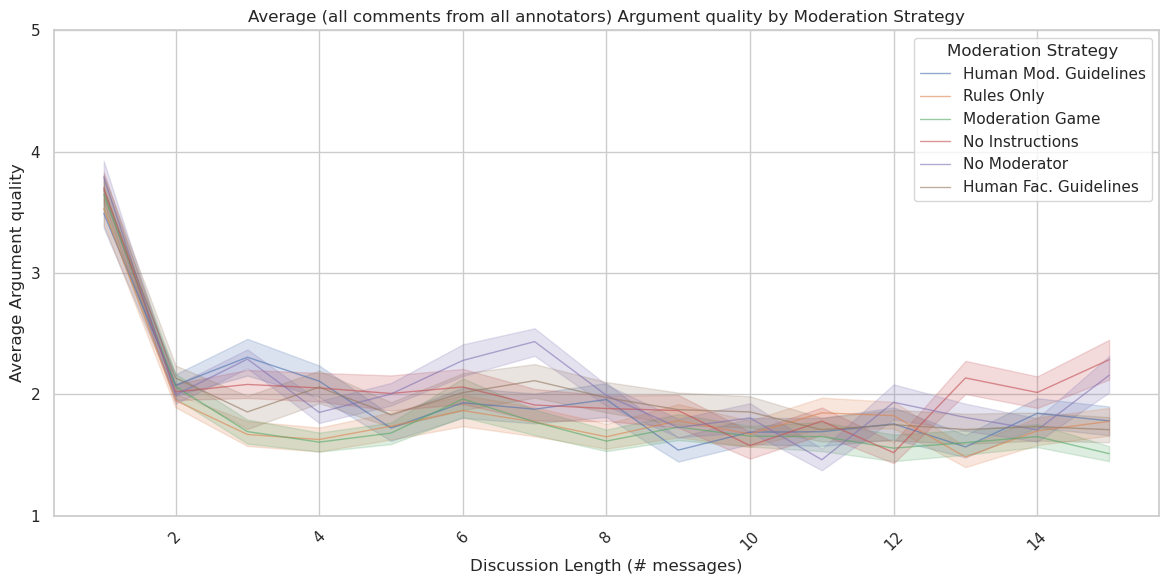

In [14]:
tasks.graphs.plot_timeseries(
    no_mod_df,
    y_col="Argument Quality",
    hue_col="conv_variant",
    hue_col_label="Moderation Strategy",
)
plt.yticks(TOXICITY_TICKS)
plt.show()

### Moderator Interventions

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/intervention_count.png


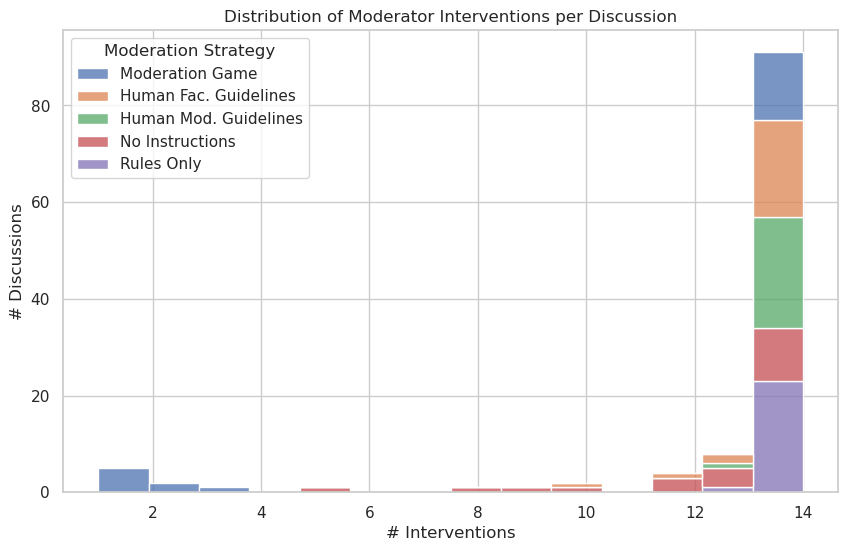

In [15]:
df_unique = df[df["conv_variant"] != "No Moderator"].drop_duplicates(
    subset=["message_id"]
)

# Compute number of moderator interventions per conversation
moderator_interventions = df_unique[df_unique["is_moderator"]].groupby("conv_id").size()

# Merge with conversation variants
conv_variants = (
    df_unique[["conv_id", "conv_variant"]].drop_duplicates().set_index("conv_id")
)
moderator_interventions = moderator_interventions.to_frame(
    name="moderator_interventions"
).join(conv_variants, how="left")

plt.figure(figsize=(10, 6))
sns.histplot(
    data=moderator_interventions.rename(
        {"conv_variant": "Moderation Strategy"}, axis=1
    ),
    x="moderator_interventions",
    hue="Moderation Strategy",
    multiple="stack",
    bins=14,
)
plt.xlabel("# Interventions")
plt.ylabel("# Discussions")
plt.title("Distribution of Moderator Interventions per Discussion")

tasks.graphs.save_plot(path=GRAPH_OUTPUT_DIR / "intervention_count.png")
plt.show()

### Annotators

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/annotator_variance.png


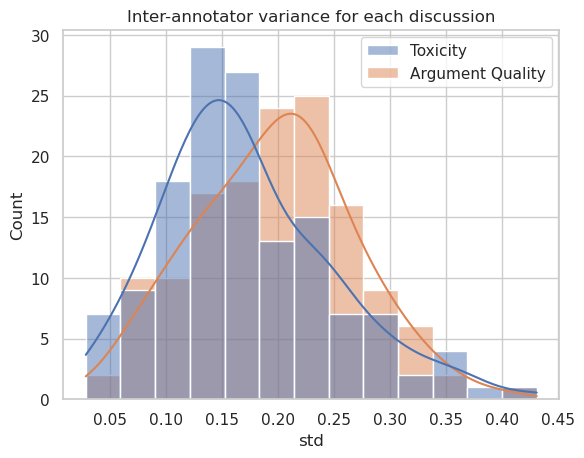

In [16]:
toxicity_var = tasks.stats.discussion_var(df, "conv_id", "message_id", "Toxicity")
argumentq_var = tasks.stats.discussion_var(df, "conv_id", "message_id", "Argument Quality")

sns.histplot([toxicity_var, argumentq_var], kde=True)
plt.title("Inter-annotator variance for each discussion")
plt.xlabel("std")

tasks.graphs.save_plot(path=GRAPH_OUTPUT_DIR / "annotator_variance.png")
plt.show()

## Investigating the rise of vanilla annotations

In [17]:
def intent_ratio(sus_df, other_df):
    other_value_counts = other_df.intent.value_counts()
    other_ratio = other_value_counts["Troll"] / other_value_counts.sum() * 100

    sus_value_counts = sus_df.intent.value_counts()
    sus_ratio = sus_value_counts["Troll"] / sus_value_counts.sum() * 100

    print(f"Suspicious area troll/other ratio: {sus_ratio:.2f}%")
    print(f"Other area troll/other ratio: {other_ratio:.2f}%")

Explain vanilla bump:

In [18]:
vanilla_df = df[df.conv_variant == "No Instructions"]
sus_df = vanilla_df[(vanilla_df.message_order <= 28) & (vanilla_df.message_order >= 23)]
other_df = vanilla_df

intent_ratio(sus_df, other_df)

Suspicious area troll/other ratio: 13.24%
Other area troll/other ratio: 8.78%


Explain moderation game bump:

In [19]:
mod_game_df = df[df.conv_variant == "Moderation Game"]
sus_df = mod_game_df[
    (mod_game_df.message_order <= 22) & (mod_game_df.message_order >= 19)
]
other_df = mod_game_df

intent_ratio(sus_df, other_df)

Suspicious area troll/other ratio: 1.75%
Other area troll/other ratio: 1.98%


Baseline: ratios on stable area

In [20]:
vanilla_df = df[df.conv_variant == "No Instructions"]
sus_df = vanilla_df[(vanilla_df.message_order <= 22) & (vanilla_df.message_order >= 19)]
other_df = vanilla_df

intent_ratio(sus_df, other_df)

Suspicious area troll/other ratio: 2.91%
Other area troll/other ratio: 8.78%


## Impact of models

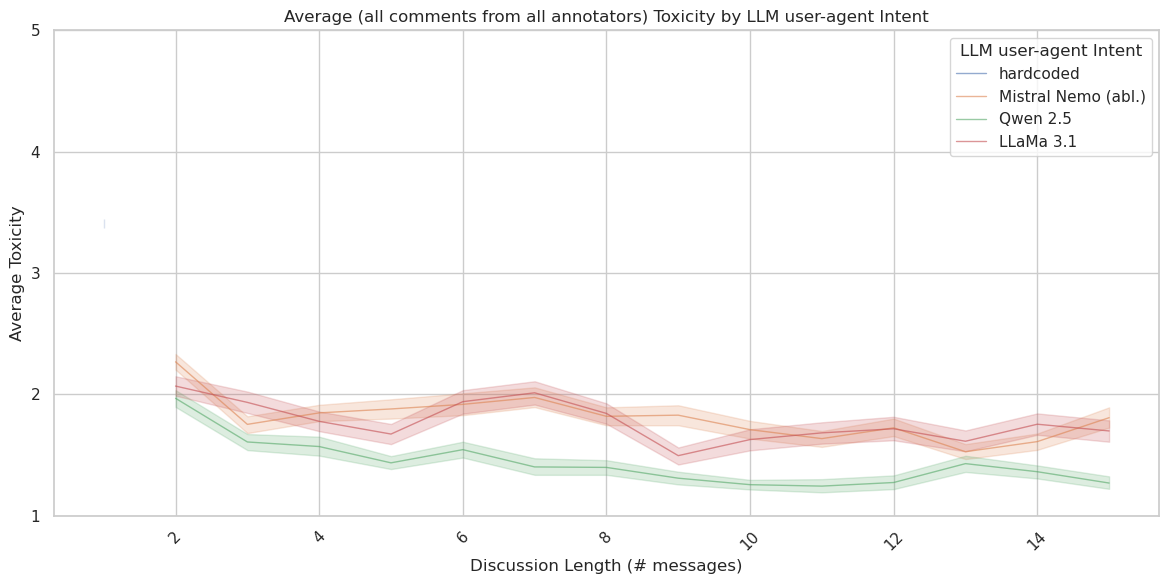

In [21]:
tasks.graphs.plot_timeseries(
    no_mod_df, y_col="Toxicity", hue_col="model", hue_col_label="LLM user-agent Intent"
)
plt.yticks(TOXICITY_TICKS)
plt.show()

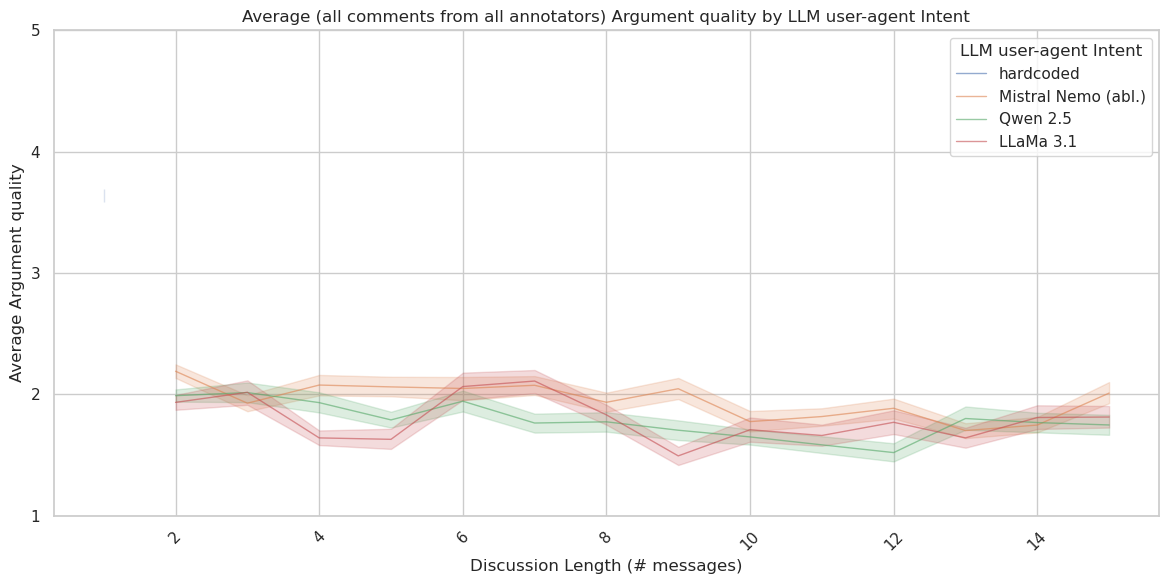

In [22]:
tasks.graphs.plot_timeseries(
    no_mod_df,
    y_col="Argument Quality",
    hue_col="model",
    hue_col_label="LLM user-agent Intent",
)
plt.yticks(TOXICITY_TICKS)
plt.show()

## Investigating the impact of moderator interventions

Draw red lines when the moderator does not intervene

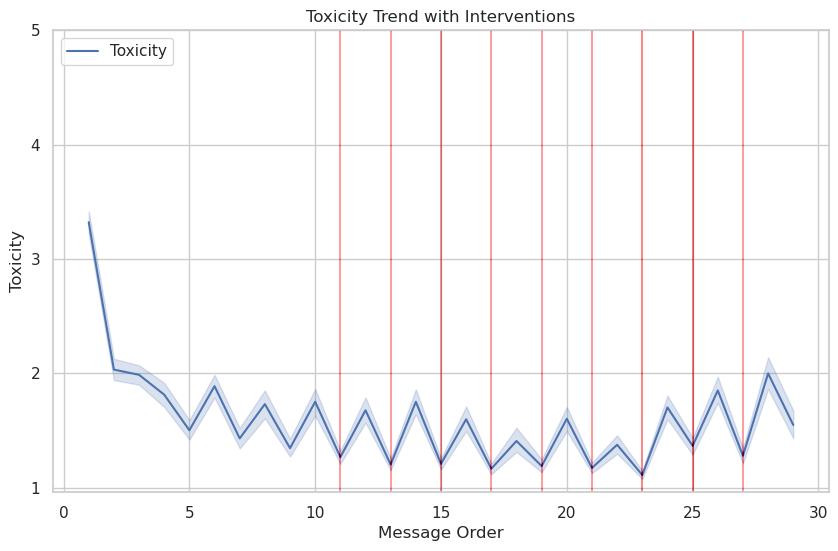

In [23]:
intervention_df = full_df[full_df.conv_variant == "No Instructions"]

plt.figure(figsize=(10, 6))
sns.lineplot(data=intervention_df, x="message_order", y="Toxicity", label="Toxicity")

# Add vertical dashed red lines where not_intervened is True
for msg_order in intervention_df.loc[
    intervention_df["not_intervened"], "message_order"
]:
    plt.axvline(x=msg_order, color="red", linestyle="dashed", lw=0.02, alpha=0.2)

plt.xlabel("Message Order")
plt.ylabel("Toxicity")
plt.title("Toxicity Trend with Interventions")
plt.yticks(TOXICITY_TICKS)

plt.show()

Repeat for each individual discussion

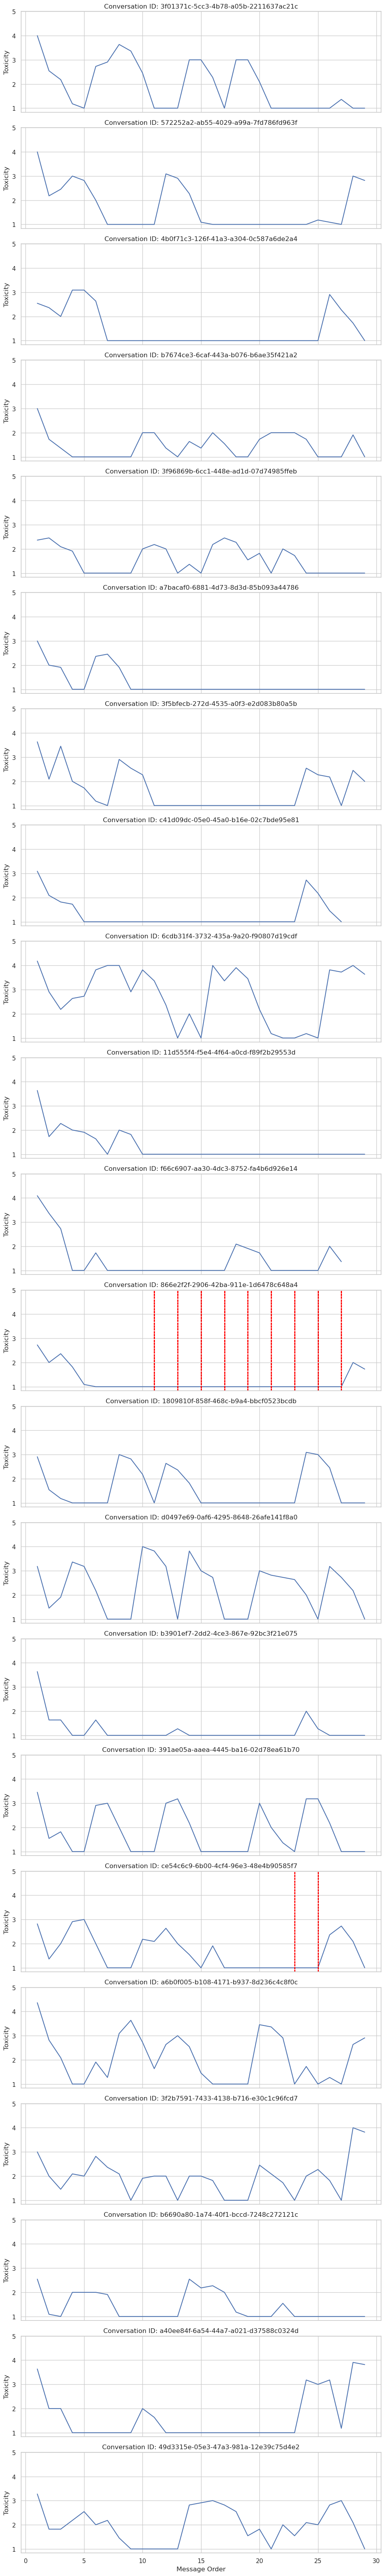

In [24]:
intervention_df = full_df[full_df.conv_variant == "No Instructions"]

# Create subplots (one for each conversation)
conv_ids = intervention_df.conv_id.unique()
fig, axes = plt.subplots(
    len(conv_ids), 1, figsize=(10, 3 * len(conv_ids)), sharex=True, sharey=True
)

if len(conv_ids) == 1:
    axes = [axes]

for ax, conv_id in zip(axes, conv_ids):
    local_df = intervention_df[intervention_df.conv_id == conv_id]

    # Lineplot for toxicity trend
    sns.lineplot(data=local_df, x="message_order", y="Toxicity", ax=ax, errorbar=None)

    # Add vertical dashed red lines for not_intervened points
    for msg_order in local_df.loc[local_df["not_intervened"], "message_order"]:
        ax.axvline(x=msg_order, color="red", linestyle="dashed", lw=1, alpha=0.5)

    ax.set_title(f"Conversation ID: {conv_id}")
    ax.set_ylabel("Toxicity")
    ax.set_yticks(TOXICITY_TICKS)


plt.xlabel("Message Order")
plt.tight_layout()
plt.show()

Non-interventions are an anomaly seen in mostly one discussion.

## User Analysis: Underlying Model

### Comment length

In [25]:
len_df = df.copy()
len_df["comment_length"] = len_df.message.apply(lambda x: len(x.split()))
len_df = len_df.loc[
    len_df.model != "hardcoded", ["message_id", "comment_length", "model"]
]
len_df = len_df.drop_duplicates(subset=["message_id"])

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/comment_length.png


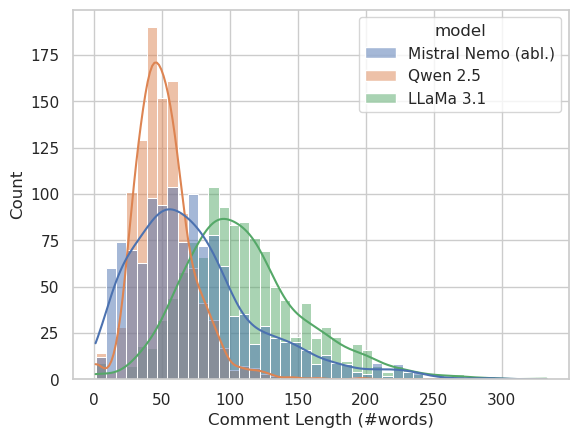

In [26]:
sns.histplot(len_df, x="comment_length", hue="model", kde=True)
plt.xlabel("Comment Length (#words)")

tasks.graphs.save_plot(GRAPH_OUTPUT_DIR / "comment_length.png")
plt.show()

In [27]:
message_df = df.copy()
message_df = message_df.drop_duplicates(subset=["conv_id", "message_id"])
# @ tokens crash bleu scorer
message_df.message = message_df.message.apply(
    lambda msg: " ".join(word for word in msg.split() if not word.startswith("@"))
)

similarity_df = (
    message_df.groupby(["conv_id", "model"])["message"]
    .apply(lambda messages: messages.tolist())
    .reset_index()
)
similarity_df.columns = ["conv_id", "model", "messages"]
similarity_df = similarity_df[similarity_df.model != "hardcoded"]

In [28]:
similarity_df["rougel_similarity"] = similarity_df.messages.progress_apply(
    tasks.stats.pairwise_rougel_similarity
)

100%|██████████| 140/140 [02:13<00:00,  1.04it/s]


Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/discussion_variance.png


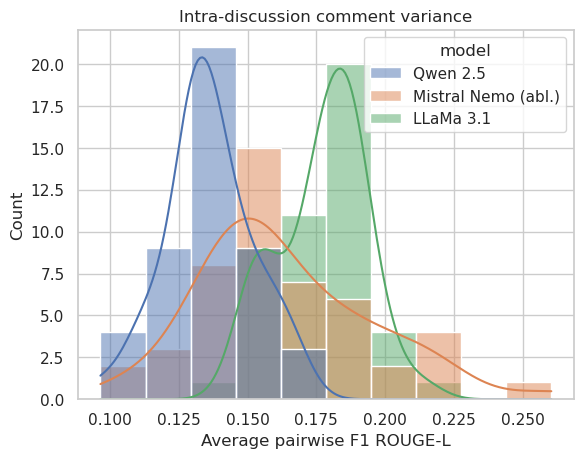

In [29]:
sns.histplot(similarity_df, x="rougel_similarity", hue="model", kde=True)
plt.xlabel("Average pairwise F1 ROUGE-L")
plt.title("Intra-discussion comment variance")

tasks.graphs.save_plot(GRAPH_OUTPUT_DIR / "discussion_variance.png")
plt.show()

## Statistical Analysis

In [30]:
analysis_df = df.loc[(df.intent != "Moderator") & (df.model != "hardcoded")]

### Moderation Strategy

#### Toxicity

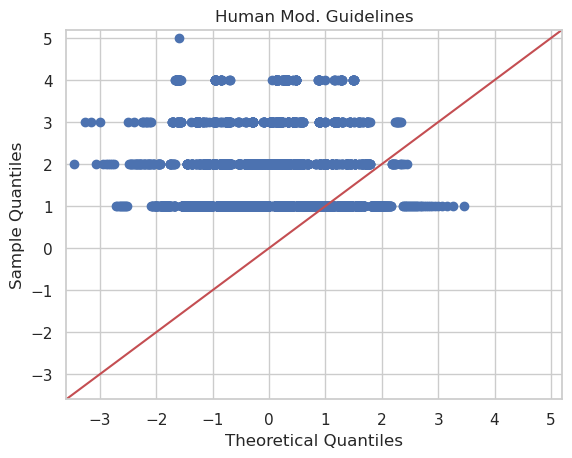

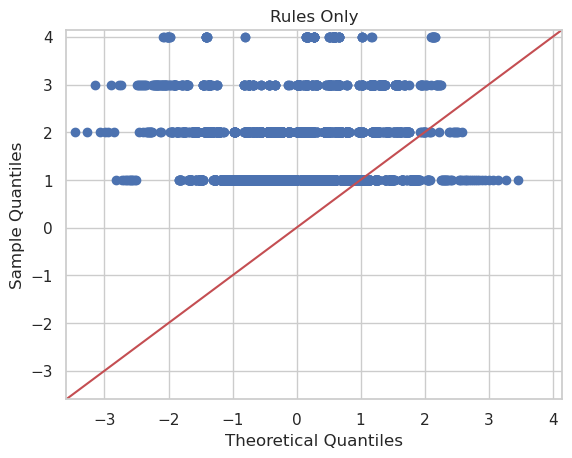

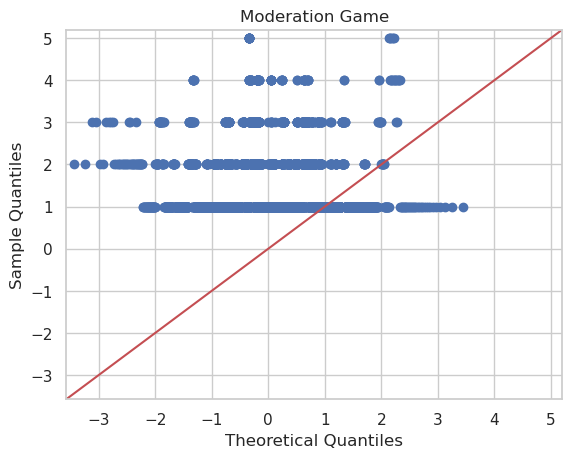

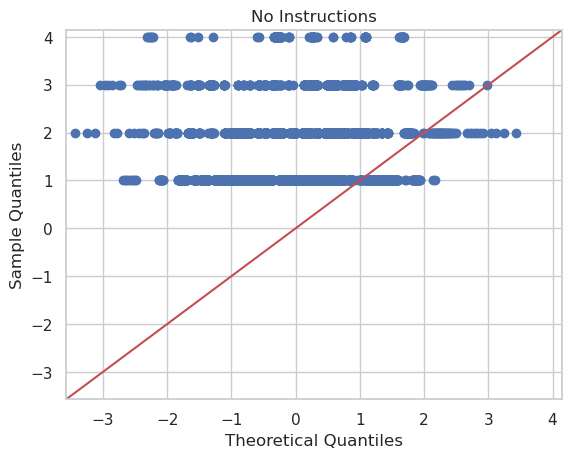

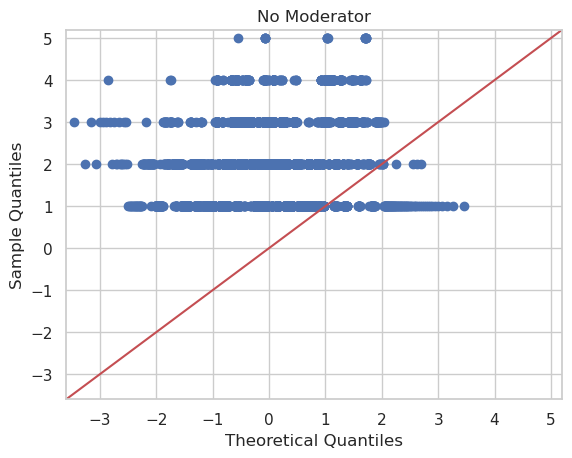

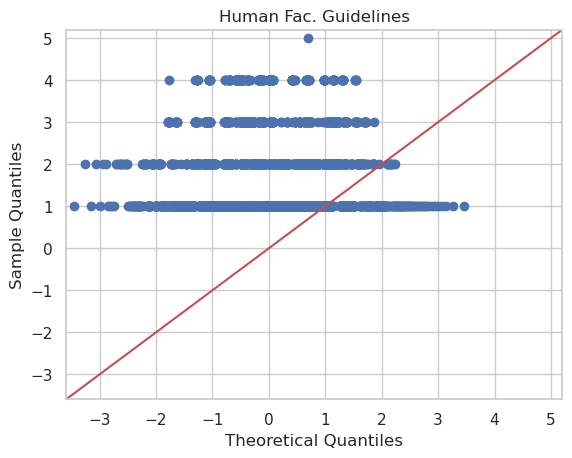

In [31]:
for conv_variant in analysis_df.conv_variant.unique():
    sm.qqplot(analysis_df.loc[analysis_df.conv_variant == conv_variant, ["Toxicity"]], line="45")
    plt.title(conv_variant)

In [32]:
groups = [
    analysis_df.loc[analysis_df.conv_variant == conv_variant, ["Toxicity"]]
    for conv_variant in analysis_df.conv_variant.unique()
]
scipy.stats.kruskal(*groups)

KruskalResult(statistic=array([761.27657463]), pvalue=array([2.7525489e-162]))

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/toxicity_stats.png


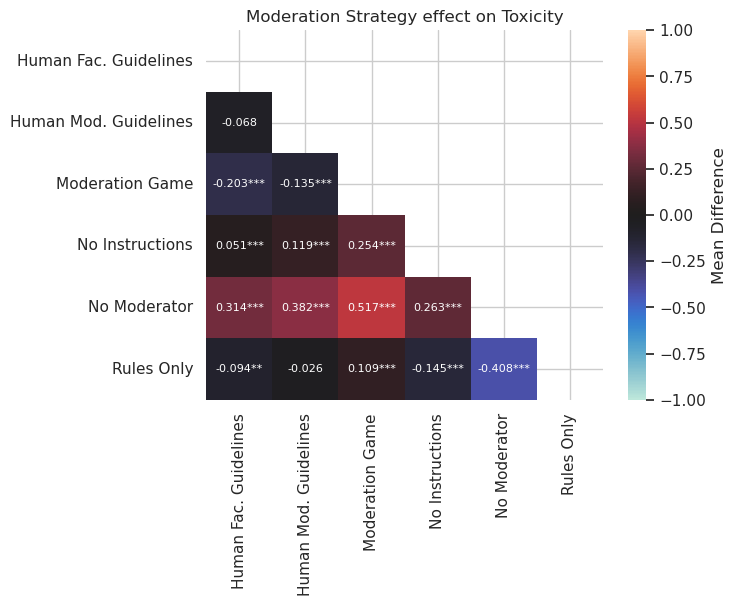

In [33]:
tasks.graphs.posthoc_dunn_heatmap(
    analysis_df,
    val_col="Toxicity",
    group_col="conv_variant",
    vmin=VMIN_TOXICITY,
    vmax=VMAX_TOXICITY,
)
plt.title("Moderation Strategy effect on Toxicity")

tasks.graphs.save_plot(GRAPH_OUTPUT_DIR / "toxicity_stats.png")
plt.show()

#### Argument Quality

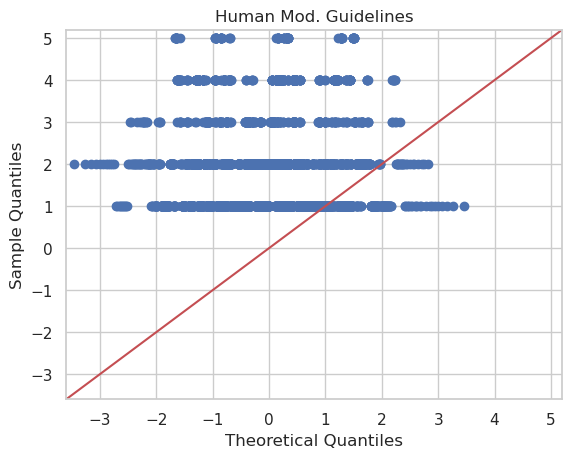

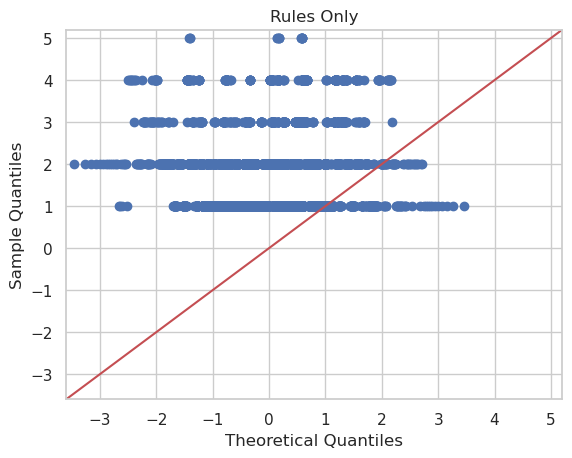

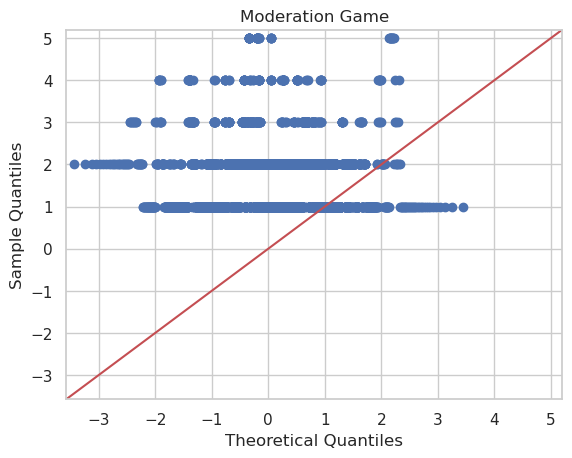

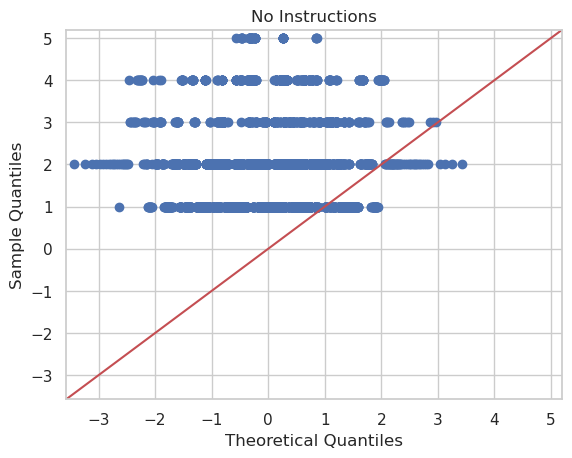

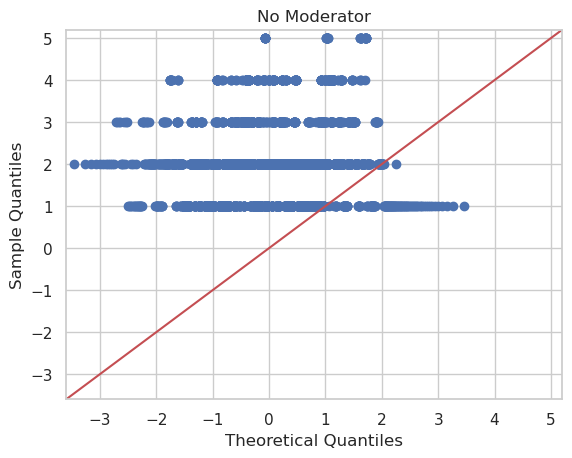

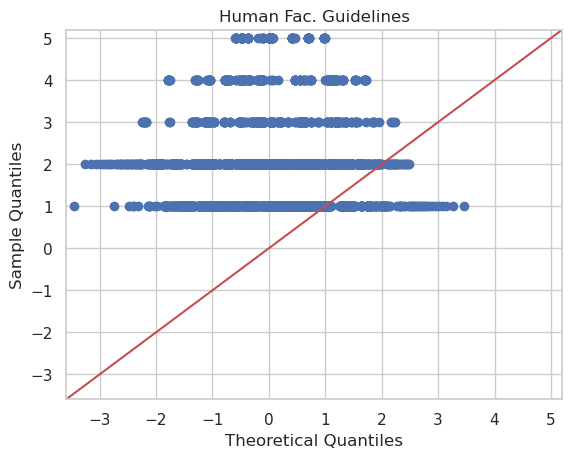

In [34]:
for conv_variant in analysis_df.conv_variant.unique():
    sm.qqplot(analysis_df.loc[analysis_df.conv_variant == conv_variant, ["Argument Quality"]], line="45")
    plt.title(conv_variant)

In [35]:
groups = [
    analysis_df.loc[analysis_df.conv_variant == conv_variant, ["Argument Quality"]]
    for conv_variant in analysis_df.conv_variant.unique()
]
scipy.stats.kruskal(*groups)

KruskalResult(statistic=array([258.22707065]), pvalue=array([9.43107463e-54]))

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/argumentq_stats.png


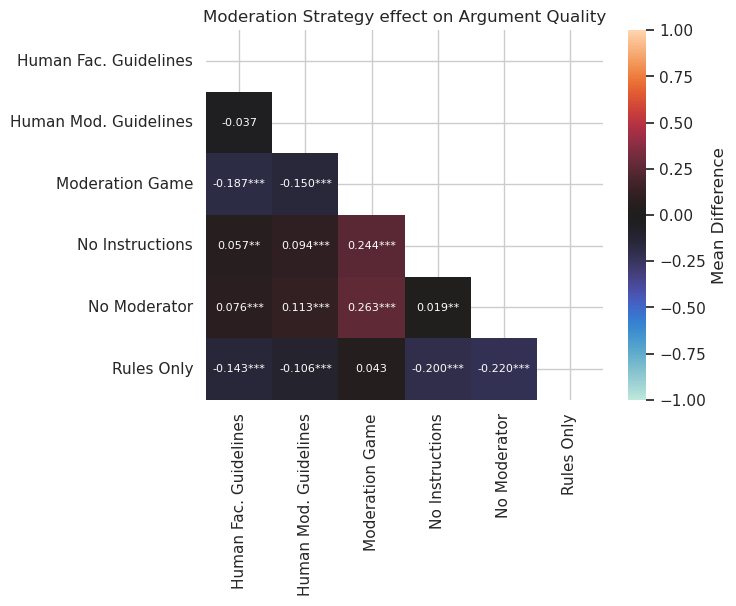

In [36]:
tasks.graphs.posthoc_dunn_heatmap(
    analysis_df,
    val_col="Argument Quality",
    group_col="conv_variant",
    vmin=VMIN_TOXICITY,
    vmax=VMAX_TOXICITY,
)
plt.title("Moderation Strategy effect on Argument Quality")

tasks.graphs.save_plot(GRAPH_OUTPUT_DIR / "argumentq_stats.png")
plt.show()